<a href="https://colab.research.google.com/github/dineshssdn-867/2018.fossasia.org/blob/master/code/Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and config files

In [1]:
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2 MB 89.4 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.4 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
plotnine 0.6.0 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
jax 0.3.4 requires scipy>=1.2.1, but you have scipy 1.1.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
import cv2
import scipy.io
import os
import gc
import sklearn.preprocessing
import matplotlib
import tensorflow
import keras.optimizers
import warnings
import scipy.io as sio
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import numpy as np
import networkx as nx
import pandas as pd
from matplotlib.animation import FuncAnimation, PillowWriter 
from keras import backend as K
from keras.models import Sequential
from keras.regularizers import l2
from keras.models import Model
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv3D, MaxPooling3D, ZeroPadding3D, AveragePooling3D 
from tensorflow.keras.layers import BatchNormalization, Activation, Input
from tensorflow.keras import layers
from scipy.misc import imresize
from keras.models import model_from_json
from datetime import datetime
from keras.utils.data_utils import get_file
from keras.utils.layer_utils import get_source_inputs
from keras.utils import layer_utils
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline

In [3]:
from keras import layers
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Conv3D
from keras.layers import MaxPooling3D
from keras.layers import AveragePooling3D
from keras.layers import Dropout
from keras.layers import Reshape
from keras.layers import Lambda
from keras.layers import GlobalAveragePooling3D

In [4]:
C3D_MEAN_PATH = 'https://github.com/adamcasson/c3d/releases/download/v0.1/c3d_mean.npy'

In [5]:
# path to pretrained models with no top (no classification layer)
WEIGHTS_PATH_NO_TOP = {
    'rgb_kinetics_only' : 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/rgb_inception_i3d_kinetics_only_tf_dim_ordering_tf_kernels_no_top.h5',
    'flow_kinetics_only' : 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/flow_inception_i3d_kinetics_only_tf_dim_ordering_tf_kernels_no_top.h5',
    'rgb_imagenet_and_kinetics' : 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/rgb_inception_i3d_imagenet_and_kinetics_tf_dim_ordering_tf_kernels_no_top.h5',
    'flow_imagenet_and_kinetics' : 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/flow_inception_i3d_imagenet_and_kinetics_tf_dim_ordering_tf_kernels_no_top.h5'
}

WEIGHTS_PATH = {
    'rgb_kinetics_only' : 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/rgb_inception_i3d_kinetics_only_tf_dim_ordering_tf_kernels.h5',
    'flow_kinetics_only' : 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/flow_inception_i3d_kinetics_only_tf_dim_ordering_tf_kernels.h5',
    'rgb_imagenet_and_kinetics' : 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/rgb_inception_i3d_imagenet_and_kinetics_tf_dim_ordering_tf_kernels.h5',
    'flow_imagenet_and_kinetics' : 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/flow_inception_i3d_imagenet_and_kinetics_tf_dim_ordering_tf_kernels.h5'
}

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Parameters

In [7]:
c3d_model_weights = '/content/drive/MyDrive/Anomaly Recognition/sports1M_weights_tf.h5'
abnormal_videos_path="/content/drive/MyDrive/Anomaly Recognition/Anomaly Videos"
normal_videos_path="/content/drive/MyDrive/Anomaly Recognition/Normal Videos/Training-Normal-Videos-Part-1"
raw_normal_train_features_c3d="/content/drive/MyDrive/Anomaly Recognition/Raw Normal videos features C3d"
raw_abnormal_train_features_c3d="/content/drive/MyDrive/Anomaly Recognition/Raw Anomaly videos features C3d"
processed_normal_train_features_c3d="/content/drive/MyDrive/Anomaly Recognition/Pre-processed Normal Video features C3d"
processed_abnormal_train_features_c3d="/content/drive/MyDrive/Anomaly Recognition/Pre-processed Anomaly video features C3d"
raw_normal_train_features_i3d="/content/drive/MyDrive/Anomaly Recognition/Raw Normal videos features i3d"
raw_abnormal_train_features_i3d="/content/drive/MyDrive/Anomaly Recognition/Raw Anomaly videos features i3d"
processed_normal_train_features_i3d="/content/drive/MyDrive/Anomaly Recognition/Pre-processed Normal Video features i3d"
processed_abnormal_train_features_i3d="/content/drive/MyDrive/Anomaly Recognition/Pre-processed Anomaly video features i3d"
output_dir = "/content/drive/MyDrive/Anomaly Recognition/Trained_models/"
output_folder_c3d = '/content/drive/MyDrive/Anomaly Recognition/output_videos'
output_folder_i3d = '/content/drive/MyDrive/Anomaly Recognition/output_videos_i3d'

In [8]:
WEIGHTS_NAME = ['rgb_kinetics_only', 'flow_kinetics_only', 'rgb_imagenet_and_kinetics', 'flow_imagenet_and_kinetics']

In [9]:
frame_height = 240
frame_width = 320
channels = 3

c3d_frame_count = 16
i3d_frame_count = 16

In [10]:
features_per_bag = 32

## Chunks work

In [11]:
def divide_chunks(l, n):
      """Apply divide_chunks to an array, getting chunks of
    of specified size
    """
    for i in range(0, len(l), n): 
        yield l[i:i + n]

## Array Util

In [12]:
def sliding_window(arr, size, stride):
    """Apply sliding window to an array, getting chunks of
    of specified size using the specified stride
    :param arr: Array to be divided
    :param size: Size of the chunks
    :param stride: Number of frames to skip for the next chunk
    :returns: Tensor with the resulting chunks
    :rtype: np.ndarray
    """
    num_chunks = int((len(arr) - size) / stride) + 2
    result = []
    for i in range(0,  num_chunks * stride, stride):
        if len(arr[i:i + size]) > 0:
            result.append(arr[i:i + size])
    return np.array(result)


def interpolate(features, features_per_bag):
    """Transform a bag with an arbitrary number of features into a bag
    with a fixed amount, using interpolation of consecutive features
    :param features: Bag of features to pad
    :param features_per_bag: Number of features to obtain
    :returns: Interpolated features
    :rtype: np.ndarray
    """
    feature_size = np.array(features).shape[1]
    interpolated_features = np.zeros((features_per_bag, feature_size))
    interpolation_indices = np.round(np.linspace(0, len(features) - 1, num=features_per_bag + 1))
    count = 0
    for index in range(0, len(interpolation_indices)-1):
        start = int(interpolation_indices[index])
        end = int(interpolation_indices[index + 1])

        assert end >= start

        if start == end:
            temp_vect = features[start, :]
        else:
            temp_vect = np.mean(features[start:end+1, :], axis=0)

        temp_vect = temp_vect / np.linalg.norm(temp_vect)

        if np.linalg.norm(temp_vect) == 0:
            print("Error")

        interpolated_features[count,:]=temp_vect
        count = count + 1
    del interpolation_indices
    gc.collect(generation=2)
    return np.array(interpolated_features)


def extrapolate(outputs, num_frames):
    """Expand output to match the video length
    :param outputs: Array of predicted outputs
    :param num_frames: Expected size of the output array
    :returns: Array of output size
    :rtype: np.ndarray
    """

    extrapolated_outputs = []
    extrapolation_indices = np.round(np.linspace(0, len(outputs) - 1, num=num_frames))
    for index in extrapolation_indices:
        extrapolated_outputs.append(outputs[int(index)])
    del extrapolation_indices
    gc.collect(generation=2)
    return np.array(extrapolated_outputs)

# Video Util

In [13]:
def get_video_clips(video_path, frame_count):
    """Divides the input video into non-overlapping clips
    :param video_path: Path to the video
    :returns: Array with the fragments of video
    :rtype: np.ndarray
    """
    frames = get_video_frames(video_path)
    clips = sliding_window(frames, frame_count, frame_count)
    return clips, len(frames)

In [14]:
def get_video_frames(video_path):
    """Reads the video given a file path
    :param video_path: Path to the video
    :returns: Video as an array of frames
    :rtype: np.ndarray
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    while (cap.isOpened()):
        ret, frame = cap.read()
        if ret == True:
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            del frame
        else:
            break
    cap.release()
    del cap
    gc.collect(generation=2)
    return frames

# Video pre-processing C3d

---



In [15]:
def preprocess_input_c3d(video):
    """Preprocess video input to make it suitable for feature extraction.
    The video is resized, cropped, resampled and training mean is substracted
    to make it suitable for the network
    :param video: Video to be processed
    :returns: Preprocessed video
    :rtype: np.ndarray
    """

    intervals = np.ceil(np.linspace(0, video.shape[0] - 1, 16)).astype(int)
    frames = video[intervals]

    # Reshape to 128x171
    reshape_frames = np.zeros((frames.shape[0], 128, 171, frames.shape[3]))
    for i, img in enumerate(frames):
        img = imresize(img, (128, 171), 'bicubic')
        reshape_frames[i, :, :, :] = img
        del img

    mean_path = get_file('c3d_mean.npy',
                         C3D_MEAN_PATH,
                         cache_subdir='models',
                         md5_hash='08a07d9761e76097985124d9e8b2fe34')

    mean = np.load(mean_path)
    reshape_frames -= mean
    # Crop to 112x112
    reshape_frames = reshape_frames[:, 8:120, 30:142, :]
    # Add extra dimension for samples
    reshape_frames = np.expand_dims(reshape_frames, axis=0)
    del intervals
    del frames
    gc.collect(generation=2)
    return reshape_frames

# Video pre-processing I3d

---



In [16]:
def preprocess_input_i3d(video):
    """Preprocess video input to make it suitable for feature extraction.
    The video is resized, cropped, resampled and training mean is substracted
    to make it suitable for the network
    :param video: Video to be processed
    :returns: Preprocessed video
    :rtype: np.ndarray
    """
    
    intervals = np.ceil(np.linspace(0, video.shape[0] - 1, 16)).astype(int)
    frames = video[intervals]

    # Reshape to 224x224
    reshape_frames = np.zeros((frames.shape[0], 224, 224, frames.shape[3]))
    for i, img in enumerate(frames):
        img = imresize(img, (224, 224), 'bicubic')
        reshape_frames[i, :, :, :] = img
        del img

    reshape_frames = np.expand_dims(reshape_frames, axis=0)
    del intervals
    del frames
    gc.collect(generation=2)
    return reshape_frames

# Segment Utils

In [17]:
def transform_into_segments(features, n_segments=32):
  """This will convert the vector 
  into 32 segments of feature vectors"""
    if features.shape[0] < n_segments:
        raise RuntimeError(
            "Number of prev segments lesser than expected output size"
        )

    cuts = np.linspace(0, features.shape[0], n_segments,
                       dtype=int, endpoint=False)

    new_feats = []
    for i, j in zip(cuts[:-1], cuts[1:]):
        new_feats.append(np.mean(features[i:j,:], axis=0))

    new_feats.append(np.mean(features[cuts[-1]:,:], axis=0))

    new_feats = np.array(new_feats)
    new_feats = sklearn.preprocessing.normalize(new_feats, axis=1)
    del cuts
    gc.collect(generation=2)
    return new_feats

# C3d

In [18]:
def C3D(weights='sports1M'):
    """Creation of the full C3D architecture
    :param weights: Weights to be loaded into the network. If None,
    the network is randomly initialized.
    :returns: Network model
    :rtype: keras.model
    """

    if weights not in {'sports1M', None}:
        raise ValueError('weights should be either be sports1M or None')

    if K.image_data_format() == 'channels_last':
        shape = (16, 112, 112, 3)
    else:
        shape = (3, 16, 112, 112)

    model = Sequential()
    model.add(
        Conv3D(64,
               3,
               activation='relu',
               padding='same',
               name='conv1',
               input_shape=shape))
    model.add(
        MaxPooling3D(pool_size=(1, 2, 2),
                     strides=(1, 2, 2),
                     padding='same',
                     name='pool1'))

    model.add(Conv3D(128, 3, activation='relu', padding='same', name='conv2'))
    model.add(
        MaxPooling3D(pool_size=(2, 2, 2),
                     strides=(2, 2, 2),
                     padding='valid',
                     name='pool2'))

    model.add(Conv3D(256, 3, activation='relu', padding='same', name='conv3a'))
    model.add(Conv3D(256, 3, activation='relu', padding='same', name='conv3b'))
    model.add(
        MaxPooling3D(pool_size=(2, 2, 2),
                     strides=(2, 2, 2),
                     padding='valid',
                     name='pool3'))

    model.add(Conv3D(512, 3, activation='relu', padding='same', name='conv4a'))
    model.add(Conv3D(512, 3, activation='relu', padding='same', name='conv4b'))
    model.add(
        MaxPooling3D(pool_size=(2, 2, 2),
                     strides=(2, 2, 2),
                     padding='valid',
                     name='pool4'))

    model.add(Conv3D(512, 3, activation='relu', padding='same', name='conv5a'))
    model.add(Conv3D(512, 3, activation='relu', padding='same', name='conv5b'))
    model.add(ZeroPadding3D(padding=(0, 1, 1)))
    model.add(
        MaxPooling3D(pool_size=(2, 2, 2),
                     strides=(2, 2, 2),
                     padding='valid',
                     name='pool5'))

    model.add(Flatten())

    model.add(Dense(4096, activation='relu', name='fc6'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu', name='fc7'))
    model.add(Dropout(0.5))
    model.add(Dense(487, activation='softmax', name='fc8'))

    if weights == 'sports1M':
        model.load_weights(c3d_model_weights)

    return model

In [19]:
def c3d_feature_extractor():
    """Creation of the feature extraction architecture. This network is
    formed by a subset of the original C3D architecture (from the
    beginning to fc6 layer)
    :returns: Feature extraction model
    :rtype: keras.model
    """
    model = C3D()
    layer_name = 'fc6'
    feature_extractor_model = Model(inputs=model.input,
                                    outputs=model.get_layer(layer_name).output)
    return feature_extractor_model

In [20]:
feature_extractor = c3d_feature_extractor()

# I3d

In [21]:
def _obtain_input_shape(input_shape,
                        default_frame_size,
                        min_frame_size,
                        default_num_frames,
                        min_num_frames,
                        data_format,
                        require_flatten,
                        weights=None):
    """Internal utility to compute/validate the model's input shape.
    (Adapted from `keras/applications/imagenet_utils.py`)
    # Arguments
        input_shape: either None (will return the default network input shape),
            or a user-provided shape to be validated.
        default_frame_size: default input frames(images) width/height for the model.
        min_frame_size: minimum input frames(images) width/height accepted by the model.
        default_num_frames: default input number of frames(images) for the model.
        min_num_frames: minimum input number of frames accepted by the model.
        data_format: image data format to use.
        require_flatten: whether the model is expected to
            be linked to a classifier via a Flatten layer.
        weights: one of `None` (random initialization)
            or 'kinetics_only' (pre-training on Kinetics dataset).
            or 'imagenet_and_kinetics' (pre-training on ImageNet and Kinetics datasets).
            If weights='kinetics_only' or weights=='imagenet_and_kinetics' then
            input channels must be equal to 3.
    # Returns
        An integer shape tuple (may include None entries).
    # Raises
        ValueError: in case of invalid argument values.
    """
    if weights != 'kinetics_only' and weights != 'imagenet_and_kinetics' and input_shape and len(input_shape) == 4:
        if data_format == 'channels_first':
            if input_shape[0] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with ' +
                    str(input_shape[0]) + ' input channels.')
            default_shape = (input_shape[0], default_num_frames, default_frame_size, default_frame_size)
        else:
            if input_shape[-1] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with ' +
                    str(input_shape[-1]) + ' input channels.')
            default_shape = (default_num_frames, default_frame_size, default_frame_size, input_shape[-1])
    else:
        if data_format == 'channels_first':
            default_shape = (3, default_num_frames, default_frame_size, default_frame_size)
        else:
            default_shape = (default_num_frames, default_frame_size, default_frame_size, 3)
    if (weights == 'kinetics_only' or weights == 'imagenet_and_kinetics') and require_flatten:
        if input_shape is not None:
            if input_shape != default_shape:
                raise ValueError('When setting`include_top=True` '
                                 'and loading `imagenet` weights, '
                                 '`input_shape` should be ' +
                                 str(default_shape) + '.')
        return default_shape

    if input_shape:
        if data_format == 'channels_first':
            if input_shape is not None:
                if len(input_shape) != 4:
                    raise ValueError(
                        '`input_shape` must be a tuple of four integers.')
                if input_shape[0] != 3 and (weights == 'kinetics_only' or weights == 'imagenet_and_kinetics'):
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')

                if input_shape[1] is not None and input_shape[1] < min_num_frames:
                    raise ValueError('Input number of frames must be at least ' +
                                     str(min_num_frames) + '; got '
                                     '`input_shape=' + str(input_shape) + '`')

                if ((input_shape[2] is not None and input_shape[2] < min_frame_size) or
                   (input_shape[3] is not None and input_shape[3] < min_frame_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_frame_size) + 'x' + str(min_frame_size) + '; got '
                                     '`input_shape=' + str(input_shape) + '`')
        else:
            if input_shape is not None:
                if len(input_shape) != 4:
                    raise ValueError(
                        '`input_shape` must be a tuple of four integers.')
                if input_shape[-1] != 3 and (weights == 'kinetics_only' or weights == 'imagenet_and_kinetics'):
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')

                if input_shape[0] is not None and input_shape[0] < min_num_frames:
                    raise ValueError('Input number of frames must be at least ' +
                                     str(min_num_frames) + '; got '
                                     '`input_shape=' + str(input_shape) + '`')

                if ((input_shape[1] is not None and input_shape[1] < min_frame_size) or
                   (input_shape[2] is not None and input_shape[2] < min_frame_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_frame_size) + 'x' + str(min_frame_size) + '; got '
                                     '`input_shape=' + str(input_shape) + '`')
    else:
        if require_flatten:
            input_shape = default_shape
        else:
            if data_format == 'channels_first':
                input_shape = (3, None, None, None)
            else:
                input_shape = (None, None, None, 3)
    if require_flatten:
        if None in input_shape:
            raise ValueError('If `include_top` is True, '
                             'you should specify a static `input_shape`. '
                             'Got `input_shape=' + str(input_shape) + '`')
    return input_shape


In [22]:
def conv3d_bn(x,
              filters,
              num_frames,
              num_row,
              num_col,
              padding='same',
              strides=(1, 1, 1),
              use_bias = False,
              use_activation_fn = True,
              use_bn = True,
              name=None):
    """Utility function to apply conv3d + BN.
    # Arguments
        x: input tensor.
        filters: filters in `Conv3D`.
        num_frames: frames (time depth) of the convolution kernel.
        num_row: height of the convolution kernel.
        num_col: width of the convolution kernel.
        padding: padding mode in `Conv3D`.
        strides: strides in `Conv3D`.
        use_bias: use bias or not  
        use_activation_fn: use an activation function or not.
        use_bn: use batch normalization or not.
        name: name of the ops; will become `name + '_conv'`
            for the convolution and `name + '_bn'` for the
            batch norm layer.
    # Returns
        Output tensor after applying `Conv3D` and `BatchNormalization`.
    """
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None

    x = Conv3D(
        filters, (num_frames, num_row, num_col),
        strides=strides,
        padding=padding,
        use_bias=use_bias,
        name=conv_name)(x)

    if use_bn:
        if K.image_data_format() == 'channels_first':
            bn_axis = 1
        else:
            bn_axis = 4
        x = BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)

    if use_activation_fn:
        x = Activation('relu', name=name)(x)

    return x

In [23]:
def Inception_Inflated3d(include_top=True,
                weights=None,
                input_tensor=None,
                input_shape=None,
                dropout_prob=0.0,
                endpoint_logit=True,
                classes=400):
    """Instantiates the Inflated 3D Inception v1 architecture.
    Optionally loads weights pre-trained
    on Kinetics. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format='channels_last'` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    Note that the default input frame(image) size for this model is 224x224.
    # Arguments
        include_top: whether to include the the classification 
            layer at the top of the network.
        weights: one of `None` (random initialization)
            or 'kinetics_only' (pre-training on Kinetics dataset only).
            or 'imagenet_and_kinetics' (pre-training on ImageNet and Kinetics datasets).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(NUM_FRAMES, 224, 224, 3)` (with `channels_last` data format)
            or `(NUM_FRAMES, 3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels.
            NUM_FRAMES should be no smaller than 8. The authors used 64
            frames per example for training and testing on kinetics dataset
            Also, Width and height should be no smaller than 32.
            E.g. `(64, 150, 150, 3)` would be one valid value.
        dropout_prob: optional, dropout probability applied in dropout layer
            after global average pooling layer. 
            0.0 means no dropout is applied, 1.0 means dropout is applied to all features.
            Note: Since Dropout is applied just before the classification
            layer, it is only useful when `include_top` is set to True.
        endpoint_logit: (boolean) optional. If True, the model's forward pass
            will end at producing logits. Otherwise, softmax is applied after producing
            the logits to produce the class probabilities prediction. Setting this parameter 
            to True is particularly useful when you want to combine results of rgb model
            and optical flow model.
            - `True` end model forward pass at logit output
            - `False` go further after logit to produce softmax predictions
            Note: This parameter is only useful when `include_top` is set to True.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    if not (weights in WEIGHTS_NAME or weights is None or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or %s' % 
                         str(WEIGHTS_NAME) + ' ' 
                         'or a valid path to a file containing `weights` values')

    if weights in WEIGHTS_NAME and include_top and classes != 400:
        raise ValueError('If using `weights` as one of these %s, with `include_top`'
                         ' as true, `classes` should be 400' % str(WEIGHTS_NAME))

    # Determine proper input shape
    input_shape = _obtain_input_shape(
        input_shape,
        default_frame_size=224, 
        min_frame_size=32, 
        default_num_frames=64,
        min_num_frames=8,
        data_format=K.image_data_format(),
        require_flatten=include_top,
        weights=weights)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 4

    # Downsampling via convolution (spatial and temporal)
    x = conv3d_bn(img_input, 64, 7, 7, 7, strides=(2, 2, 2), padding='same', name='Conv3d_1a_7x7')

    # Downsampling (spatial only)
    x = MaxPooling3D((1, 3, 3), strides=(1, 2, 2), padding='same', name='MaxPool2d_2a_3x3')(x)
    x = conv3d_bn(x, 64, 1, 1, 1, strides=(1, 1, 1), padding='same', name='Conv3d_2b_1x1')
    x = conv3d_bn(x, 192, 3, 3, 3, strides=(1, 1, 1), padding='same', name='Conv3d_2c_3x3')

    # Downsampling (spatial only)
    x = MaxPooling3D((1, 3, 3), strides=(1, 2, 2), padding='same', name='MaxPool2d_3a_3x3')(x)

    # Mixed 3b
    branch_0 = conv3d_bn(x, 64, 1, 1, 1, padding='same', name='Conv3d_3b_0a_1x1')

    branch_1 = conv3d_bn(x, 96, 1, 1, 1, padding='same', name='Conv3d_3b_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 128, 3, 3, 3, padding='same', name='Conv3d_3b_1b_3x3')

    branch_2 = conv3d_bn(x, 16, 1, 1, 1, padding='same', name='Conv3d_3b_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 32, 3, 3, 3, padding='same', name='Conv3d_3b_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_3b_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 32, 1, 1, 1, padding='same', name='Conv3d_3b_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_3b')

    # Mixed 3c
    branch_0 = conv3d_bn(x, 128, 1, 1, 1, padding='same', name='Conv3d_3c_0a_1x1')

    branch_1 = conv3d_bn(x, 128, 1, 1, 1, padding='same', name='Conv3d_3c_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 192, 3, 3, 3, padding='same', name='Conv3d_3c_1b_3x3')

    branch_2 = conv3d_bn(x, 32, 1, 1, 1, padding='same', name='Conv3d_3c_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 96, 3, 3, 3, padding='same', name='Conv3d_3c_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_3c_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 64, 1, 1, 1, padding='same', name='Conv3d_3c_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_3c')


    # Downsampling (spatial and temporal)
    x = MaxPooling3D((3, 3, 3), strides=(2, 2, 2), padding='same', name='MaxPool2d_4a_3x3')(x)

    # Mixed 4b
    branch_0 = conv3d_bn(x, 192, 1, 1, 1, padding='same', name='Conv3d_4b_0a_1x1')

    branch_1 = conv3d_bn(x, 96, 1, 1, 1, padding='same', name='Conv3d_4b_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 208, 3, 3, 3, padding='same', name='Conv3d_4b_1b_3x3')

    branch_2 = conv3d_bn(x, 16, 1, 1, 1, padding='same', name='Conv3d_4b_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 48, 3, 3, 3, padding='same', name='Conv3d_4b_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_4b_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 64, 1, 1, 1, padding='same', name='Conv3d_4b_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_4b')

    # Mixed 4c
    branch_0 = conv3d_bn(x, 160, 1, 1, 1, padding='same', name='Conv3d_4c_0a_1x1')

    branch_1 = conv3d_bn(x, 112, 1, 1, 1, padding='same', name='Conv3d_4c_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 224, 3, 3, 3, padding='same', name='Conv3d_4c_1b_3x3')

    branch_2 = conv3d_bn(x, 24, 1, 1, 1, padding='same', name='Conv3d_4c_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 64, 3, 3, 3, padding='same', name='Conv3d_4c_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_4c_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 64, 1, 1, 1, padding='same', name='Conv3d_4c_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_4c')

    # Mixed 4d
    branch_0 = conv3d_bn(x, 128, 1, 1, 1, padding='same', name='Conv3d_4d_0a_1x1')

    branch_1 = conv3d_bn(x, 128, 1, 1, 1, padding='same', name='Conv3d_4d_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 256, 3, 3, 3, padding='same', name='Conv3d_4d_1b_3x3')

    branch_2 = conv3d_bn(x, 24, 1, 1, 1, padding='same', name='Conv3d_4d_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 64, 3, 3, 3, padding='same', name='Conv3d_4d_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_4d_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 64, 1, 1, 1, padding='same', name='Conv3d_4d_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_4d')

    # Mixed 4e
    branch_0 = conv3d_bn(x, 112, 1, 1, 1, padding='same', name='Conv3d_4e_0a_1x1')

    branch_1 = conv3d_bn(x, 144, 1, 1, 1, padding='same', name='Conv3d_4e_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 288, 3, 3, 3, padding='same', name='Conv3d_4e_1b_3x3')

    branch_2 = conv3d_bn(x, 32, 1, 1, 1, padding='same', name='Conv3d_4e_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 64, 3, 3, 3, padding='same', name='Conv3d_4e_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_4e_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 64, 1, 1, 1, padding='same', name='Conv3d_4e_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_4e')

    # Mixed 4f
    branch_0 = conv3d_bn(x, 256, 1, 1, 1, padding='same', name='Conv3d_4f_0a_1x1')

    branch_1 = conv3d_bn(x, 160, 1, 1, 1, padding='same', name='Conv3d_4f_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 320, 3, 3, 3, padding='same', name='Conv3d_4f_1b_3x3')

    branch_2 = conv3d_bn(x, 32, 1, 1, 1, padding='same', name='Conv3d_4f_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 128, 3, 3, 3, padding='same', name='Conv3d_4f_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_4f_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 128, 1, 1, 1, padding='same', name='Conv3d_4f_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_4f')


    # Downsampling (spatial and temporal)
    x = MaxPooling3D((2, 2, 2), strides=(2, 2, 2), padding='same', name='MaxPool2d_5a_2x2')(x)

    # Mixed 5b
    branch_0 = conv3d_bn(x, 256, 1, 1, 1, padding='same', name='Conv3d_5b_0a_1x1')

    branch_1 = conv3d_bn(x, 160, 1, 1, 1, padding='same', name='Conv3d_5b_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 320, 3, 3, 3, padding='same', name='Conv3d_5b_1b_3x3')

    branch_2 = conv3d_bn(x, 32, 1, 1, 1, padding='same', name='Conv3d_5b_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 128, 3, 3, 3, padding='same', name='Conv3d_5b_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_5b_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 128, 1, 1, 1, padding='same', name='Conv3d_5b_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_5b')

    # Mixed 5c
    branch_0 = conv3d_bn(x, 384, 1, 1, 1, padding='same', name='Conv3d_5c_0a_1x1')

    branch_1 = conv3d_bn(x, 192, 1, 1, 1, padding='same', name='Conv3d_5c_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 384, 3, 3, 3, padding='same', name='Conv3d_5c_1b_3x3')

    branch_2 = conv3d_bn(x, 48, 1, 1, 1, padding='same', name='Conv3d_5c_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 128, 3, 3, 3, padding='same', name='Conv3d_5c_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_5c_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 128, 1, 1, 1, padding='same', name='Conv3d_5c_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_5c')

    if include_top:
        # Classification block
        x = AveragePooling3D((2, 7, 7), strides=(1, 1, 1), padding='valid', name='global_avg_pool')(x)
        x = Dropout(dropout_prob)(x)

        x = conv3d_bn(x, classes, 1, 1, 1, padding='same', 
                use_bias=True, use_activation_fn=False, use_bn=False, name='Conv3d_6a_1x1')
 
        num_frames_remaining = int(x.shape[1])
        x = Reshape((num_frames_remaining, classes))(x)

        # logits (raw scores for each class)
        x = Lambda(lambda x: K.mean(x, axis=1, keepdims=False),
                   output_shape=lambda s: (s[0], s[2]))(x)

        if not endpoint_logit:
            x = Activation('softmax', name='prediction')(x)
    else:
        h = int(x.shape[2])
        w = int(x.shape[3])
        x = AveragePooling3D((2, h, w), strides=(1, 1, 1), padding='valid', name='global_avg_pool')(x)



    inputs = img_input
    # create model
    model = Model(inputs, x, name='i3d_inception')

    # load weights
    if weights in WEIGHTS_NAME:
        if weights == WEIGHTS_NAME[0]:   # rgb_kinetics_only
            if include_top:
                weights_url = WEIGHTS_PATH['rgb_kinetics_only']
                model_name = 'i3d_inception_rgb_kinetics_only.h5'
            else:
                weights_url = WEIGHTS_PATH_NO_TOP['rgb_kinetics_only']
                model_name = 'i3d_inception_rgb_kinetics_only_no_top.h5'

        elif weights == WEIGHTS_NAME[1]: # flow_kinetics_only
            if include_top:
                weights_url = WEIGHTS_PATH['flow_kinetics_only']
                model_name = 'i3d_inception_flow_kinetics_only.h5'
            else:
                weights_url = WEIGHTS_PATH_NO_TOP['flow_kinetics_only']
                model_name = 'i3d_inception_flow_kinetics_only_no_top.h5'

        elif weights == WEIGHTS_NAME[2]: # rgb_imagenet_and_kinetics
            if include_top:
                weights_url = WEIGHTS_PATH['rgb_imagenet_and_kinetics']
                model_name = 'i3d_inception_rgb_imagenet_and_kinetics.h5'
            else:
                weights_url = WEIGHTS_PATH_NO_TOP['rgb_imagenet_and_kinetics']
                model_name = 'i3d_inception_rgb_imagenet_and_kinetics_no_top.h5'

        elif weights == WEIGHTS_NAME[3]: # flow_imagenet_and_kinetics
            if include_top:
                weights_url = WEIGHTS_PATH['flow_imagenet_and_kinetics']
                model_name = 'i3d_inception_flow_imagenet_and_kinetics.h5'
            else:
                weights_url = WEIGHTS_PATH_NO_TOP['flow_imagenet_and_kinetics']
                model_name = 'i3d_inception_flow_imagenet_and_kinetics_no_top.h5'

        downloaded_weights_path = get_file(model_name, weights_url, cache_subdir='models')
        model.load_weights(downloaded_weights_path)

        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first' and K.backend() == 'tensorflow':
            warnings.warn('You are using the TensorFlow backend, yet you '
                          'are using the Theano '
                          'image data format convention '
                          '(`image_data_format="channels_first"`). '
                          'For best performance, set '
                          '`image_data_format="channels_last"` in '
                          'your keras config '
                          'at ~/.keras/keras.json.')

    elif weights is not None:
        model.load_weights(weights)

    return model

In [24]:
model_i3d_feature_extract = Inception_Inflated3d(include_top=False,
                weights='rgb_imagenet_and_kinetics',
                input_shape=(16,224,224,3),
                dropout_prob=0.0,
                endpoint_logit=True,
                classes=400)

49610752/49595336 [==============================] - 6s 0us/step


In [ ]:
model_i3d_feature_extract.summary()

# Extract Features

## Normal Videos

In [23]:
normal_videos = os.listdir(normal_videos_path)
normal_videos.sort()
chunk = list(divide_chunks(normal_videos, 5))

### I3d

In [ ]:
print("Processing normal videos...")
for vid_name in chunk[7]:
    print("Processing {}".format(vid_name))
    vid_path = os.path.join(normal_videos_path, vid_name)
    feats_path = os.path.join(
        raw_normal_train_features_i3d, vid_name[:-9] + ".npy"
    )

    clips, frames = get_video_clips(vid_path, i3d_frame_count)

    # Remove last clip if number of frames is not equal to 16
    if frames % 16 != 0:
        clips = clips[:-1]
    
    print(frames)
    print(len(clips))
    if frames > 1700 or frames < 1500:
      continue

    prep_clips = [preprocess_input_i3d(np.array(clip)) for clip in clips]
    prep_clips = np.vstack(prep_clips)

    features = model_i3d_feature_extract(prep_clips)

    features = np.reshape(features, (features.shape[0], features.shape[4]))
    features = sklearn.preprocessing.normalize(features, axis=1)
    del prep_clips
    
    with open(feats_path,"wb") as f: 
        np.save(f, features)
      
    del features
    gc.collect(generation=2)

In [199]:
raw_abnormal_train_features_i3d_list=os.listdir(raw_normal_train_features_i3d)
for filename in os.listdir(raw_normal_train_features_i3d):
    print("Processing {}".format(filename))
    raw_file_path = os.path.join(
        raw_normal_train_features_i3d, filename
    )
    processed_file_path = os.path.join(
        processed_normal_train_features_i3d, filename
    )
    with open(raw_file_path, "rb") as f:
        feats = np.load(f, allow_pickle=True)

    try:
        new_feats = transform_into_segments(feats)
        with open(processed_file_path, "wb") as f:
            np.save(f, new_feats, allow_pickle=True)
    except RuntimeError:
        print("Video {} too short".format(filename))

Processing Normal_Videos154.npy
Processing Normal_Videos156.npy
Processing Normal_Videos159.npy
Processing Normal_Videos162.npy
Processing Normal_Videos170.npy
Processing Normal_Videos173.npy
Processing Normal_Videos178.npy
Processing Normal_Videos204.npy
Processing Normal_Videos209.npy
Processing Normal_Videos215.npy
Processing Normal_Videos218.npy
Processing Normal_Videos_717.npy
Processing Normal_Videos_725.npy
Processing Normal_Videos_745.npy
Video Normal_Videos_745.npy too short
Processing Normal_Videos_778.npy
Processing Normal_Videos_828.npy
Processing Normal_Videos_831.npy
Video Normal_Videos_831.npy too short
Processing Normal_Videos_866.npy
Processing Normal_Videos_867.npy
Processing Normal_Videos_870.npy
Processing Normal_Videos_872.npy
Processing Normal_Videos_876.npy
Video Normal_Videos_876.npy too short
Processing Normal_Videos_878.npy
Video Normal_Videos_878.npy too short
Processing Normal_Videos_879.npy
Processing Normal_Videos_881.npy
Video Normal_Videos_881.npy too sh

In [110]:
len(os.listdir('/content/drive/MyDrive/Anomaly Recognition/Pre-processed Normal Video features i3d'))

65

## Anomaly Videos

In [22]:
abnormal_videos = os.listdir(abnormal_videos_path)
abnormal_videos.sort()
chunk = list(divide_chunks(abnormal_videos, 5))

### C3d

In [ ]:
print("Processing abnormal videos in chunks...")
for vid_name in chunk:
    print("Processing {}".format(vid_name))
    vid_path = os.path.join(abnormal_videos_path, vid_name)
    feats_path = os.path.join(
        raw_abnormal_train_features_c3d, vid_name[:-9] + ".npy"
    )

    clips, frames = get_video_clips(vid_path, c3d_frame_count)
    print(frames)
    if frames > 8000:
      continue
    # Remove last clip if number of frames is not equal to 16
    if frames % 16 != 0:
        clips = clips[:-1]

    prep_clips = [preprocess_input_c3d(np.array(clip)) for clip in clips]
    prep_clips = np.vstack(prep_clips)

    features = feature_extractor.predict(prep_clips)
    del prep_clips
    features = sklearn.preprocessing.normalize(features, axis=1)   
    with open(feats_path, "wb") as f:
        np.save(f, features)
    del features
    gc.collect(generation=2)

In [ ]:
raw_abnormal_train_features_c3d_list=os.listdir(raw_abnormal_train_features_c3d)
for filename in os.listdir(raw_abnormal_train_features_c3d):
    print("Processing {}".format(filename))
    raw_file_path = os.path.join(
        raw_abnormal_train_features_c3d, filename
    )
    processed_file_path = os.path.join(
        processed_abnormal_train_features_c3d, filename
    )
    with open(raw_file_path, "rb") as f:
        feats = np.load(f, allow_pickle=True)

    try:
        new_feats = transform_into_segments(feats)
        with open(processed_file_path, "wb") as f:
            np.save(f, new_feats, allow_pickle=True)
    except RuntimeError:
        print("Video {} too short".format(filename))

### i3d

In [ ]:
print("Processing abnormal videos in chunks...")
for vid_name in chunk[12]:
    print("Processing {}".format(vid_name))
    vid_path = os.path.join(abnormal_videos_path, vid_name)
    feats_path = os.path.join(
        raw_abnormal_train_features_i3d, vid_name[:-9] + ".npy"
    )

    clips, frames = get_video_clips(vid_path, i3d_frame_count)
    print(frames)
    if frames > 4000 or frames < 2000:
      continue
    # Remove last clip if number of frames is not equal to 16
    if frames % 16 != 0:
        clips = clips[:-1]

    prep_clips = [preprocess_input_i3d(np.array(clip)) for clip in clips]
    prep_clips = np.vstack(prep_clips)

    features = model_i3d_feature_extract.predict(prep_clips)
    features = np.reshape(features, (features.shape[0], features.shape[4]))
    features = sklearn.preprocessing.normalize(features, axis=1)
    del prep_clips 
    with open(feats_path, "wb") as f:
        np.save(f, features)
    del features
    gc.collect(generation=2)

In [145]:
raw_abnormal_train_features_c3d_list=os.listdir(raw_abnormal_train_features_i3d)
for filename in os.listdir(raw_abnormal_train_features_i3d):
    print("Processing {}".format(filename))
    raw_file_path = os.path.join(
        raw_abnormal_train_features_i3d, filename
    )
    processed_file_path = os.path.join(
        processed_abnormal_train_features_i3d, filename
    )
    with open(raw_file_path, "rb") as f:
        feats = np.load(f, allow_pickle=True)

    try:
        new_feats = transform_into_segments(feats)
        with open(processed_file_path, "wb") as f:
            np.save(f, new_feats, allow_pickle=True)
    except RuntimeError:
        print("Video {} too short".format(filename))

Processing Abuse041.npy
Processing Abuse046.npy
Processing Arson044.npy
Processing Arson047.npy
Processing Arson051.npy
Processing Assault044.npy
Processing Assault045.npy
Processing Assault049.npy
Processing Assault050.npy
Processing Assault051.npy
Processing Burglary050.npy
Processing Burglary092.npy
Processing Burglary093.npy
Processing Burglary094.npy
Processing Burglary098.npy
Processing Explosion047.npy
Processing Explosion048.npy
Video Explosion048.npy too short
Processing RoadAccidents143.npy
Processing RoadAccidents145.npy
Processing RoadAccidents146.npy
Processing RoadAccidents150.npy
Processing RoadAccidents151.npy
Processing Robbery143.npy
Processing Robbery144.npy
Processing Robbery145.npy
Processing Robbery147.npy
Processing Robbery149.npy
Processing Shooting027.npy
Processing Shooting040.npy
Processing Shooting041.npy
Processing Shooting051.npy
Processing Shooting053.npy
Processing Shoplifting028.npy
Processing Stealing105.npy
Processing Stealing106.npy
Processing Steali

# AI Train

## Parameters for traning model

In [26]:
normal_list_c3d = os.listdir(processed_normal_train_features_c3d)
normal_list_c3d.sort()
abnormal_list_c3d = os.listdir(processed_abnormal_train_features_c3d)
abnormal_list_c3d.sort()
normal_list_i3d = os.listdir(processed_normal_train_features_i3d)
normal_list_i3d.sort()
abnormal_list_i3d = os.listdir(processed_abnormal_train_features_i3d)
abnormal_list_i3d.sort()
weights_path_c3d = output_dir + 'weights_c3d.mat'
model_path_c3d = output_dir + 'model_c3d.json'
weights_path_i3d = output_dir + 'weights_i3d.mat'
model_path_i3d = output_dir + 'model_i3d.json'

## DNN Model C3d

In [57]:
def classifier_c3d_model():
    """Build the classifier
    :returns: Classifier model
    :rtype: keras.Model
    """
    model = Sequential()
    model.add(Dense(512, input_dim=4096, kernel_initializer='glorot_normal',
                    kernel_regularizer=l2(0.001), activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(32, kernel_initializer='glorot_normal',
                    kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.6))
    model.add(Dense(1, kernel_initializer='glorot_normal',
                    kernel_regularizer=l2(0.001), activation='sigmoid'))
    return model

## DNN Model i3d

In [28]:
def classifier_i3d_model():
    """Build the classifier
    :returns: Classifier model
    :rtype: keras.Model
    """
    model = Sequential()
    model.add(Dense(512, input_dim=1024, kernel_initializer='glorot_normal',activation='relu'))
    model.add(Dense(256, input_dim=512, kernel_initializer='glorot_normal', activation='relu'))
    model.add(Dense(32, kernel_initializer='glorot_normal'))
    model.add(Dense(1, kernel_initializer='glorot_normal', activation='sigmoid'))
    return model

## Data loading

In [29]:
def load_batch_train(normal_path, normal_list, abnormal_path, abnormal_list):

    batchsize=60
    n_exp = int(batchsize/2)

    num_normal = len(normal_list)
    num_abnormal = len(abnormal_list)

    abnor_list_idx = np.random.permutation(num_abnormal)
    abnor_list = abnor_list_idx[:n_exp]
    norm_list_idx = np.random.permutation(num_normal)
    norm_list = norm_list_idx[:n_exp]

    abnormal_feats = []
    for video_idx in abnor_list:
        video_path = os.path.join(abnormal_path, abnormal_list[video_idx])
        with open(video_path, "rb") as f:
            feats = np.load(f)
        abnormal_feats.append(feats)

    normal_feats = []
    for video_idx in norm_list:
        video_path = os.path.join(normal_path, normal_list[video_idx])
        with open(video_path, "rb") as f:
            feats = np.load(f)
        normal_feats.append(feats)


    all_feats = np.vstack((*abnormal_feats, *normal_feats))
    all_labels = np.zeros(32*batchsize, dtype='uint8')

    all_labels[:32*n_exp] = 1

    return  all_feats, all_labels

## Loss function

In [30]:
def custom_objective(y_true, y_pred):

    y_true = K.reshape(y_true, [-1])
    y_pred = K.reshape(y_pred, [-1])
    n_seg = 32
    nvid = 60
    n_exp = int(nvid / 2)

    max_scores_list = []
    z_scores_list = []
    temporal_constrains_list = []
    sparsity_constrains_list = []

    for i in range(0, n_exp, 1):

        video_predictions = y_pred[i*n_seg:(i+1)*n_seg]

        max_scores_list.append(K.max(video_predictions))
        temporal_constrains_list.append(
            K.sum(K.pow(video_predictions[1:] - video_predictions[:-1], 2))
        )
        sparsity_constrains_list.append(K.sum(video_predictions))

    for j in range(n_exp, 2*n_exp, 1):

        video_predictions = y_pred[j*n_seg:(j+1)*n_seg]
        max_scores_list.append(K.max(video_predictions))

    max_scores = K.stack(max_scores_list)
    temporal_constrains = K.stack(temporal_constrains_list)
    sparsity_constrains = K.stack(sparsity_constrains_list)

    for ii in range(0, n_exp, 1):
        max_z = K.maximum(1 - max_scores[:n_exp] + max_scores[n_exp+ii], 0)
        z_scores_list.append(K.sum(max_z))

    z_scores = K.stack(z_scores_list)
    z = K.mean(z_scores)

    return z + \
        0.00008*K.sum(temporal_constrains) + \
        0.00008*K.sum(sparsity_constrains)

## Model Initialization 

In [58]:
#Create Full connected Model
model_c3d = classifier_c3d_model()
model_i3d = classifier_i3d_model()

## Compile model and define some parameters

In [ ]:
adagrad = tf.keras.optimizers.Adagrad(lr=0.001, epsilon=1e-08)
model_c3d.compile(loss=custom_objective, optimizer=adagrad)
model_i3d.compile(loss=custom_objective, optimizer=adagrad)

In [60]:
if not os.path.exists(output_dir):
       os.makedirs(output_dir)

loss_graph =[]
num_iters = 4000
total_iterations = 0
batchsize=32
time_before = datetime.now()

## Train Model C3d

In [61]:
Loss, epochs = [], []

In [ ]:
for it_num in range(num_iters):
  inputs, targets = load_batch_train(
        processed_normal_train_features_c3d, normal_list_c3d, processed_abnormal_train_features_c3d, abnormal_list_c3d
  )
  batch_loss = model_c3d.train_on_batch(inputs, targets)
  loss_graph = np.hstack((loss_graph, batch_loss))
  total_iterations += 1
  if total_iterations % 20 == 0:
    epochs.append(total_iterations)
    Loss.append(batch_loss)
    print ("Iteration={} took: {}, loss: {}".format(
            total_iterations, datetime.now() - time_before, batch_loss)
      )

In [ ]:
plt.plot(epochs, Loss)
plt.xlabel('epochs') 
plt.ylabel('loss') 
  
# displaying the title
plt.title("Loss vs epochs graph")
plt.show()

## Train Model I3d

In [ ]:
Loss, epochs = [], []

In [ ]:
for it_num in range(num_iters):
  inputs, targets = load_batch_train(
        processed_normal_train_features_i3d, normal_list_i3d, processed_abnormal_train_features_i3d, abnormal_list_i3d
  )
  batch_loss = model_i3d.train_on_batch(inputs, targets)
  loss_graph = np.hstack((loss_graph, batch_loss))
  total_iterations += 1
  if total_iterations % 20 == 0:
    epochs.append(total_iterations)
    Loss.append(batch_loss)
    print ("Iteration={} took: {}, loss: {}".format(
            total_iterations, datetime.now() - time_before, batch_loss)
      )

Iteration=240 took: 0:01:31.529735, loss: 2.269014596939087


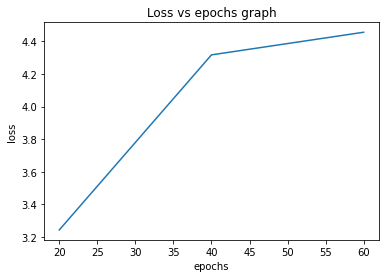

In [ ]:
plt.plot(epochs, Loss)
plt.xlabel('epochs') 
plt.ylabel('loss') 
  
# displaying the title
plt.title("Loss vs epochs graph")
plt.show()

## Saving model

In [325]:
def load_model(json_path):
    model = model_from_json(open(json_path).read())
    return model

In [326]:
def save_model(model, json_path, weight_path):
    json_string = model.to_json()
    open(json_path, 'w').write(json_string)
    dict = {}
    i = 0
    for layer in model.layers:
        weights = layer.get_weights()
        my_list = np.zeros(len(weights), dtype=np.object)
        my_list[:] = weights
        dict[str(i)] = my_list
        i += 1
    scipy.io.savemat(weight_path, dict)

### I3d

In [ ]:
print("Train Successful - Model saved")
save_model(model_i3d, model_path_i3d, weights_path_i3d)

### C3d

In [ ]:
print("Train Successful - Model saved")
save_model(model_c3d, model_path_c3d, weights_path_c3d)

## Load Model

In [33]:
def conv_dict(dict2):
    """Prepare the dictionary of weights to be loaded by the network
    :param dict2: Dictionary to format
    :returns: The dictionary properly formatted
    :rtype: dict
    """
    dict = {}
    for i in range(len(dict2)):
        if str(i) in dict2:
            if dict2[str(i)].shape == (0, 0):
                dict[str(i)] = dict2[str(i)]
            else:
                weights = dict2[str(i)][0]
                weights2 = []
                for weight in weights:
                    if weight.shape in [(1, x) for x in range(0, 5000)]:
                        weights2.append(weight[0])
                    else:
                        weights2.append(weight)
                dict[str(i)] = weights2
    return dict

In [34]:
def load_weights(model, weights_file):
    """Loads the pretrained weights into the network architecture
    :param model: keras model of the network
    :param weights_file: Path to the weights file
    :returns: The input model with the weights properly loaded
    :rtype: keras.model
    """
    dict2 = sio.loadmat(weights_file)
    dict = conv_dict(dict2)
    i = 0
    for layer in model.layers:
        weights = dict[str(i)]
        layer.set_weights(weights)
        i += 1
    return model

In [35]:
def build_classifier_model(model, weights_path):
    """Build the classifier and load the pretrained weights
    :returns:
    :rtype:
    """
    model = load_weights(model, weights_path)
    return model

In [36]:
model_c3d = build_classifier_model(model_c3d, weights_path_c3d)
model_i3d = build_classifier_model(model_i3d, weights_path_i3d)

# Visualize

In [37]:
def visualize_clip(clip, convert_bgr=False, save_gif=False, file_path=None):
    num_frames = len(clip)
    fig, ax = plt.subplots()
    fig.set_tight_layout(True)

    def update(i):
        if convert_bgr:
            frame = cv2.cvtColor(clip[i], cv2.COLOR_BGR2RGB)
        else:
            frame = clip[i]
        plt.imshow(frame)
        return plt

    # FuncAnimation will call the 'update' function for each frame; here
    # animating over 10 frames, with an interval of 20ms between frames.
    anim = FuncAnimation(fig, update, frames=np.arange(0, num_frames), interval=1)
    if save_gif:
        anim.save(file_path, dpi=80, writer='pillow')
    else:
        # plt.show() will just loop the animation forever.
        plt.show()

In [38]:
def visualize_predictions(video_path, predictions, save_path):
    frames = get_video_frames(video_path)
    assert len(frames) == len(predictions)

    fig, ax = plt.subplots(figsize=(5, 5))
    fig.set_tight_layout(True)

    line = matplotlib.lines.Line2D([], [])

    fig_frame = plt.subplot(2, 1, 1)
    img = fig_frame.imshow(frames[0])
    fig_prediction = plt.subplot(2, 1, 2)
    fig_prediction.set_xlim(0, len(frames))
    fig_prediction.set_ylim(0, 1.15)
    fig_prediction.add_line(line)

    def update(i):
        frame = frames[i]
        x = range(0, i)
        y = predictions[0:i]
        line.set_data(x, y)
        img.set_data(frame)
        return plt

    # FuncAnimation will call the 'update' function for each frame; here
    # animating over 10 frames, with an interval of 20ms between frames.

    anim = FuncAnimation(fig, update, frames=np.arange(0, len(frames), 10), interval=1, repeat=False)

    if save_path:
        anim.save(save_path, dpi=200, writer=PillowWriter(fps=20))
    else:
        plt.show()

#### I3d

In [39]:
def run_demo_i3d(sample_video_path, video_name):
    # read video
    video_clips, num_frames = get_video_clips(sample_video_path, c3d_frame_count)

    print("Number of clips in the video : ", len(video_clips))

    # build models
    feature_extractor = model_i3d_feature_extract
    classifier_model = model_i3d

    print("Models initialized")

    # extract features
    rgb_features = []
    for i, clip in enumerate(video_clips):
        clip = np.array(clip)
        if len(clip) < c3d_frame_count:
            continue

        clip = preprocess_input_i3d(clip)
        rgb_feature = feature_extractor.predict(clip)[0]
        rgb_features.append(rgb_feature)

        print("Processed clip : ", i)

    rgb_features = np.array(rgb_features)
    rgb_features = np.reshape(rgb_features, (rgb_features.shape[0], rgb_features.shape[4]))
    rgb_feature_bag = interpolate(rgb_features, features_per_bag)
    
    # classify using the trained classifier model
    predictions = classifier_model.predict(rgb_feature_bag)

    predictions = np.array(predictions).squeeze()

    predictions = extrapolate(predictions, num_frames)
    
    save_path = os.path.join(output_folder_i3d, video_name + '.gif')
    # visualize predictions
    print('Executed Successfully - '+video_name + '.gif saved')
    visualize_predictions(sample_video_path, predictions, save_path)

#### C3d

In [43]:
def run_demo_c3d(sample_video_path, video_name):
    # read video
    video_clips, num_frames = get_video_clips(sample_video_path, c3d_frame_count)

    print("Number of clips in the video : ", len(video_clips))

    # build models
    feature_extractor = c3d_feature_extractor()
    classifier_model = model_c3d

    print("Models initialized")

    # extract features
    rgb_features = []
    for i, clip in enumerate(video_clips):
        clip = np.array(clip)
        if len(clip) < c3d_frame_count:
            continue

        clip = preprocess_input_c3d(clip)
        rgb_feature = feature_extractor.predict(clip)[0]
        rgb_features.append(rgb_feature)

        print("Processed clip : ", i)

    rgb_features = np.array(rgb_features)
    print(rgb_features.shape)
    rgb_feature_bag = interpolate(rgb_features, features_per_bag)
    
    # classify using the trained classifier model
    predictions = classifier_model.predict(rgb_feature_bag)

    predictions = np.array(predictions).squeeze()

    predictions = extrapolate(predictions, num_frames)
    
    save_path = os.path.join(output_folder_c3d, video_name + '_10.gif')
    # visualize predictions
    print('Executed Successfully - '+video_name + '.gif saved')
    visualize_predictions(sample_video_path, predictions, save_path)

In [ ]:
run_demo_c3d('/content/Shooting050_x264.mp4', 'Shooting050_x264')

# c3d testing

In [ ]:
run_demo_c3d('/content/Shooting050_x264.mp4', 'Shooting050_x264')

# i3d testing

In [ ]:
run_demo_i3d('/content/Shooting050_x264.mp4', 'Shooting050_x264')